In [6]:
%load_ext autoreload

## 0) Preamble

### Set path variables

In [7]:
import sys
import os

PROJECT_PATH = '../../'
NESTA_PATH = f'{os.environ["HOME"]}/Nesta/nesta'
SQL_CONF_PATH = f'{os.environ["HOME"]}/Nesta-AWS/AWS-RDS-config/innovation-mapping-5712.config'
AWS_SUBSCRIPTION_KEY = '951506285b4649c19065b282ac4e63c4'

sys.path += [PROJECT_PATH, NESTA_PATH]

### Imports and load data

In [8]:
%matplotlib inline
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json
import itertools
from collections import Counter, defaultdict
from cord19.transformers.utils import get_engine
from cord19.transformers.utils import contains_keyword  # Specifies keywords ('SARS-CoV-2', 'COVID-19', 'coronavirus')
from nesta.packages.mag.query_mag_api import build_expr
from nesta.packages.mag.query_mag_api import query_mag_api

ModuleNotFoundError: No module named 'yaml'

In [7]:
%%time
con = get_engine(SQL_CONF_PATH)
columns = ['id', 'created', 'title', 'abstract', 'mag_id', 'citation_count', 'article_source']
chunks = pd.read_sql_table('arxiv_articles', con, columns=columns, chunksize=1000)
covid_df = [df.loc[df.abstract.apply(contains_keyword) | df.title.apply(contains_keyword)]
            for df in chunks]
covid_df = pd.concat(covid_df)

/Users/jklinger/anaconda3/envs/py36/lib/python3.6/site-packages/pymysql/cursors.py:166: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  result = self._query(query)


CPU times: user 1min 22s, sys: 10.1 s, total: 1min 32s
Wall time: 2min 46s


### Get MAG IDs for "covid+AI" articles

In [8]:
with open(f"{PROJECT_PATH}/data/raw/ai_paper_ids.json") as f:
    ai_paper_ids = json.load(f)
condition = covid_df.id.apply(lambda id: id in ai_paper_ids)
mag_ids = [int(id) for id in covid_df.mag_id.loc[condition] if not pd.isnull(id)]

In [9]:
print("Total AI paper IDs", len(ai_paper_ids))
print("Subtotal with valid MAG IDs", len(mag_ids))

Total AI paper IDs 215
Subtotal with valid MAG IDs 175


## 1) Get citation info from available MAG IDs

In [10]:
# Get the citation info
for expr in build_expr(mag_ids, 'Id'):
    result = query_mag_api(expr, fields=['Id', 'CitCon'], subscription_key=AWS_SUBSCRIPTION_KEY)

In [11]:
# Mapping of {citing article id --> [list of citation article ids]}
citers = {str(article['Id']): list(article['CitCon'].keys()) 
          if 'CitCon' in article else [] for article in result['entities']}

# Set of ids of all cited articles
citee_ids = set(int(id) for id in itertools.chain.from_iterable(citers.values()))

f"Number of unique citees: {len(citee_ids)}"

'Number of unique citees: 1397'

In [12]:
# Get full info for each citation
results = []
query_count = 1000
for expr in build_expr(citee_ids.union(citers), 'Id'):
    count, offset = query_count, 0
    # Do until no results left
    while count == query_count:
        _result = query_mag_api(expr, fields=['Id', 'J.JN', 'D', 'DN', 'DOI', 'CC', 'F.FN'], 
                                subscription_key=AWS_SUBSCRIPTION_KEY, 
                                offset=offset, query_count=query_count)['entities']      
        
        count = len(_result)
        offset += count
        results += _result
        
# Data quality: check that we returned all of the citation IDs
returned_ids = {r['Id'] for r in results}
len(citee_ids - returned_ids), len(set(citers) - returned_ids)  # <-- these should be zero!

(0, 0)

## 2) Save the citation information for later

In [13]:
# Look up for flattened variable names
field_dictionary = {'CC': 'citations', 
                    'D': 'date',
                    'DN': 'title',
                    'F': lambda x: {'fields_of_study': [_x['FN'] for _x in x]},
                    'Id': 'mag_id',
                    'J': lambda x: {'journal_title': x['JN']}}

# Mapping of all article ids (both citers and citees) --> flattened article data
articles = {}
for r in results:
    article = {}
    # Convert the field names from MAG to something legible
    for mag_key, field in field_dictionary.items():
        # Ignore this MAG field if the result doesn't have it!
        if mag_key not in r:
            continue
        # If the mapping is str --> value
        if type(field) is str:
            article[field] = r[mag_key]
        # Otherwise assume that the mapping is a lambda function
        else:
            article.update(field(r[mag_key]))
    articles[str(r['Id'])] = article

# Mapping of all article ids (both citers and citees) --> flattened article data
with open(f'{PROJECT_PATH}/data/processed/ai_article_mag_info.json', 'w') as f:
    f.write(json.dumps(articles))

# Citer ids. Together with `articles` you've got everything you need
with open(f'{PROJECT_PATH}/data/processed/citation_lookup.json', 'w') as f:
    f.write(json.dumps(citers))

## 3) Cross-tab FoS in articles and FoS of citations

In [16]:
def get_fos(articles, citers):
    """Get the fields of study for citers and citees"""
    fos_articles = []  # citers
    fos_citations = []  # citees
    for id, article in articles.items():
        if id not in citers:
            continue
        _fos_articles = article['fields_of_study']
        # For citations, flatten the list
        _fos_citations = list(itertools.chain.from_iterable(articles[c]["fields_of_study"] for c in citers[id]))
        fos_articles += _fos_articles
        fos_citations += _fos_citations
    return fos_articles, fos_citations

In [15]:
fos_articles, fos_citations = get_fos(articles, citers)

# Get the 15 most common fields of study for plotting
fa_most_common = [f for f, _ in Counter(fos_articles).most_common(15)]
fc_most_common = [f for f, _ in Counter(fos_citations).most_common(15)]

print(f"Most common FoS in citing articles: {fa_most_common}")
print(f"Most common FoS in cited articles: {fc_most_common}")

# Create a lookup of {citer FoS --> citee FoS --> count}
# Note: this can be readily converted to DataFrame cross-tab
cross_tab = defaultdict(lambda: defaultdict(int))
for id, article in articles.items():
    if id not in citers:
        continue
    # Get the fields of study
    _fos_articles = [f for f in article['fields_of_study'] if f in fa_most_common]
    # As before, for citations, flatten the list
    _fos_citations = list(itertools.chain.from_iterable(articles[int(c)]["fields_of_study"] for c in citers[id]))
    _fos_citations = [f for f in _fos_citations if f in fc_most_common]
    # Increment the cross-tab
    for fa in _fos_articles:
        for fc in _fos_citations:
            cross_tab[fa][fc] += 1

Most common FoS in citing articles: ['artificial intelligence', 'coronavirus disease 2019', 'computer science', 'machine learning', 'deep learning', 'medicine', 'coronavirus', 'biology', 'convolutional neural network', 'pattern recognition', 'severe acute respiratory syndrome coronavirus 2', 'pandemic', 'computed tomography', 'disease', 'outbreak']
Most common FoS in cited articles: ['artificial intelligence', 'computer science', 'medicine', 'machine learning', 'pattern recognition', 'coronavirus disease 2019', 'deep learning', 'biology', 'severe acute respiratory syndrome coronavirus 2', 'convolutional neural network', 'artificial neural network', 'computer vision', 'coronavirus', 'virology', '2019 20 coronavirus outbreak']


Text(68.99999999999999, 0.5, 'Articles by field of study')

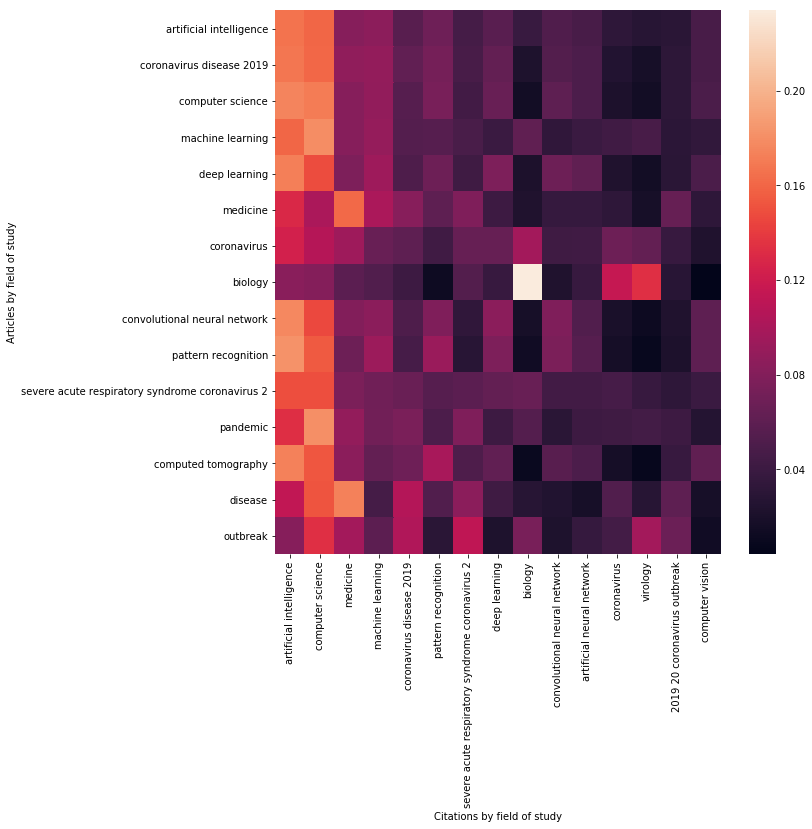

In [16]:
# Normalise, sort and plot the cross-tab
fig, ax = plt.subplots(figsize=(10,10))
_cross_tab = pd.DataFrame(cross_tab, columns=fa_most_common, index=fc_most_common).T
_cross_tab_sum = _cross_tab.sum(axis=1) 
cross_tab_norm = _cross_tab.apply(lambda row: row/_cross_tab_sum, axis=0)
sorted_columns = cross_tab_norm.sum().sort_values(ascending=False).index
cross_tab_norm = cross_tab_norm[sorted_columns]
sns.heatmap(pd.DataFrame(cross_tab_norm), ax=ax)
ax.set_xlabel("Citations by field of study")
ax.set_ylabel("Articles by field of study")

## 4) Field of study semantic differences

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [19]:
# Mapping of all article ids (both citers and citees) --> flattened article data
with open(f'{PROJECT_PATH}/data/processed/ai_article_mag_info.json') as f:
    articles = json.load(f)
    
# Citer ids. Together with `articles` you've got everything you need
with open(f'{PROJECT_PATH}/data/processed/citation_lookup.json') as f:
    citers = json.load(f)
    
# Get the fields of study for citers and citees
fos_articles, fos_citations = get_fos(articles, citers)
fa_most_common = [f for f, _ in Counter(fos_articles).most_common(15)]
fc_most_common = [f for f, _ in Counter(fos_citations).most_common(15)]

In [20]:
fa_most_common[0] 

'artificial intelligence'

In [23]:
fc_most_common[0]

'artificial intelligence'

In [34]:
import numpy as np
a = embed(fa_most_common)
c = embed(fc_most_common)

for TERM, row in zip(fa_most_common, np.inner(a, c)):
    print(TERM)
    for term, sim in zip(fc_most_common, row):
        print("\t", term, sim)
    print()

artificial intelligence
	 artificial intelligence 1.0000002
	 computer science 0.41696027
	 medicine 0.19788225
	 machine learning 0.5775031
	 pattern recognition 0.25437605
	 coronavirus disease 2019 0.20546761
	 deep learning 0.5663028
	 biology 0.28462332
	 severe acute respiratory syndrome coronavirus 2 0.13357906
	 convolutional neural network 0.44763976
	 artificial neural network 0.6573779
	 computer vision 0.39607766
	 coronavirus 0.17420861
	 virology 0.17667301
	 2019 20 coronavirus outbreak 0.13414928

coronavirus disease 2019
	 artificial intelligence 0.20546761
	 computer science 0.039695986
	 medicine 0.17025161
	 machine learning 0.18605027
	 pattern recognition -0.01155198
	 coronavirus disease 2019 0.99999994
	 deep learning 0.19852594
	 biology 0.16625506
	 severe acute respiratory syndrome coronavirus 2 0.32733974
	 convolutional neural network 0.16883266
	 artificial neural network 0.24012345
	 computer vision 0.026914466
	 coronavirus 0.27345586
	 virology 0.277645

In [30]:
# median similarity of FoSs of article with the abstract vs 
# median similarity of FoSs of citations with the abstract

In [31]:
row

array([1.0000002 , 0.41696027, 0.19788225, 0.5775031 , 0.25437605,
       0.20546761, 0.5663028 , 0.28462332, 0.13357906, 0.44763976,
       0.6573779 , 0.39607766, 0.17420861, 0.17667301, 0.13414928],
      dtype=float32)